# Recurrent Neural Network

## (0) Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf

# Checking data types
from typing import Dict, List, Tuple, Sequence
import string

## (1) 📚 The dataset

### (1.1) Loading the dataset

💾 Load it.

In [7]:
df = pd.read_csv('../data/pollution/inputs/Xy_PA75016.csv',index_col='Date_time')
df = df.reset_index(drop=True)

In [8]:
df

,PM25,PM10,NO2,ATMO
0,0.000000,-0.001422,-0.732394,4
1,0.000000,-0.001422,-0.732394,4
2,0.000000,-0.001422,-0.732394,4
3,0.000000,-0.001422,-0.732394,4
4,0.000000,-0.025605,-0.510563,4
...,...,...,...,...
1770,-0.562911,-0.504979,-0.517606,4
1771,-0.633635,0.012802,-0.278169,4
1772,-1.473684,-0.315789,-0.880282,3
1773,-0.908306,1.544808,1.109155,3


In [57]:
df['ATMO'].value_counts()

4    899
5    721
3    150
2      4
1      1
Name: ATMO, dtype: int64

In [81]:
baseline = 899/1775
baseline

0.5064788732394366

👆 *(Reminders*) This weather dataset is a ***single Time Series*** represented as a DataFrame, i.e. a **2D-array**.
- `df.shape = (n_timesteps, n_features)`
    - `n_timesteps` $= 23$k rows  (_~8 years of weather data, from 2009 to 2016 with records every 3 hours_)
    - `n_features` $= 19$ features composed of:
        - $1$ <font color=green>**target**</font> (we will use the past values of the temperature as a feature)
        - $18$ <font color=orange>**past covariates**</font> (= features which past values are known)
        - $0$ <font color=blue>**future covariates**</font> (= features which future values are known, e.g. public holidays)
    
<img src='https://github.com/lewagon/data-images/blob/master/DL/time-series-covariates.png?raw=true'>    

### (1.2) 🌅 The big picture about dealing with Time Series *(reminder)*

1️⃣ <b>[FOLDS] <u>Cross-Validation in Time Series  </u></b>

Starting from this single Time Series:
- We will create <font color="#c91ac9">**FOLDS**</font>
- <font color=blue>**Train**</font>/<font color="#ff8005">**Evaluate**</font> our LSTM  <font color="#c91ac9">**on each of these different FOLDS**</font> to conclude about <b><u>the robustness of the model</u><b>.
    
_It is very common to create hundreds of folds in Time Series forecasting, in order to cover all types of external conditions: crash market periods, bull markets, atone markets, etc..._

2️⃣ <b>[TRAIN-TEST SPLIT] <u>Holdout method</u></b>

For each <font color="#c91ac9">**FOLD**</font>, we will do a <font color=blue>**TRAIN**</font>-<font color="#ff8005">**TEST**</font> SPLIT to:
* <font color=blue>**fit**</font> the model on the <font color=blue>**train**</font> set 
* <font color="#ff8005">**evaluate**</font> it on the <font color="#ff8005">**test**</font> set

_Always split the train set **chronologically** before the test set!_

<hr> 

👇 The first two steps can be summarized in the following image (here, we illustrated a 4-fold temporal cross-validation):

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/time_series_cross_validation.png" alt="Time Series Cross Validation" width="800" height="400">

<hr>

3️⃣ <b>[SEQUENCES] <u>Sampling/Extracting sequences</u></b>


After splitting each fold into a <font color="blue">train</font> set and a <font color="#ff8005">test</font> set, it is time to:
- 🏋 sample lots of <font color="#884dff"><i>sequences</i></font> $\color{blue}{(X_i, y_i)}$ on which the model will be <font color="blue">trained</font>
- 👩🏻‍🏫 sample lots of <font color="#884dff"><i>sequences</i></font> $\color{#ff8005}{(X_i, y_i)}$ on which the model will be <font color="#ff8005">evaluated</font>


<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="500" height="500"> 

👉 All these <font color="#884dff"><i>sequences</i></font> in the <font color="blue">train</font> set and the <font color="#ff8005">test</font> set will have a common shape `(input_length, n_features)` $ = (14\times8,19) = (112,19)$.

👉 Each <font color="#884dff"><i>sequence</i></font> has a target, the shape of which will be `(output_length, n_targets)` $ = (7\times8, 1) = (56, 1)$.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/shapes_for_input_sequence_and_ouput_sequence.png" alt="3d arrays time series" width="1200" height="800"> 

<hr>

> 🔥 Open this [**infograph**](https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/big_picture_temporal_data_handling.png)  side-by-side with the notebook for a visual summary! 🔥

## (2) Adapting the functions from the _"Predict Temperature"_ challenge

### (2.0) Global Variables

🌐 Let's define some ***global variables*** that we will use for our tests everywhere in this notebook:

In [9]:
# Folds
FOLD_LENGTH = 521      # dont 365J Train +  156J Test
FOLD_STRIDE = int(209) # sliding each semester - décalage de 209J pour obtenir 7 folds

# Temporal Train-Test split
TRAIN_TEST_RATIO = 0.7 #70% de train et 30% de test par fold
#N_TRAIN = 365 # number_of_sequences_train for each fold_train
#N_TEST = 156 # number_of_sequences_test for each fold_test

# Inputs
N_FEATURES = 4  # 3 polluants + l'ATMO index
INPUT_LENGTH = 7 # - Records 1 week ~ 7 days. One week is quite common for air quality  

# Outputs
TARGET = ['ATMO']
TARGET_COLUMN_IDX = 3 # Corresponds to the third column of the df
N_TARGETS = 1
OUTPUT_LENGTH = N_TARGETS*7 # Predicting one target, the ATMO index for 7 days
                              

# Additional parameters
HORIZON = 1 # - You want to predict this point HORIZON = 1 day after the last known value

### (2.1)  🗂 <font color="#c91ac9">FOLDS</font>

🎁 **`get_folds`**

You have already coded this function in *Challenge 3 - Predict Weather Temperature*. <br> _Feel free to ask the teacher any questions if something is still not clear._

In [10]:
def get_folds(df: pd.DataFrame, 
              fold_length: int,
              fold_stride: int) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''

    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

👉 Let's generate these <font color="#c91ac9">**FOLDS**</font>.

In [11]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')
np.array(folds).shape

The function generated 7 folds.
Each fold has a shape equal to (521, 4).


(7, 521, 4)

7 Folds

521 Observation (fold_length)

4 features (3 polluant + 1target )

🧪 Make sure that the following <font color=green>***assert***</font> doesn't return anything (which means the assertion is correct).

In [12]:
assert(folds[0].shape == (521, 4))

☝️ This amount of <font color="#c91ac9">**FOLDS**</font> should be enough to cross-validate our model correctly!

### (2.2) ✂️  Temporal <font color=blue>Train</font>/<font color="#ff8005">Test</font> Split

👩🏻‍🏫 Let's <font color="#c91ac9">focus on one fold</font> for the moment, the first one for example.

In [13]:
fold = folds[0]
fold

,PM25,PM10,NO2,ATMO
0,0.000000,-0.001422,-0.732394,4
1,0.000000,-0.001422,-0.732394,4
2,0.000000,-0.001422,-0.732394,4
3,0.000000,-0.001422,-0.732394,4
4,0.000000,-0.025605,-0.510563,4
...,...,...,...,...
516,1.043586,0.588905,0.404930,5
517,0.314145,-0.115220,-0.098592,5
518,0.213816,-0.065434,-0.070423,5
519,0.158306,0.183499,-0.253521,4


⌚️ We want to ***split this <font color="#c91ac9">fold</font> chronologically*** into a <font color=blue>***fold_train***</font> and a <font color="#ff8005">***fold_test***</font>.

*Each of these fold_train and fold_test will contain all the data we need to be able to sample many pairs `(Xi, yi)` in a next step!*

#### (2.2.1) 🧑🏻‍🏫 The complexity introduced by the <font color=green>gap</font>

<details>
    <summary>⏸ Let's take a <i>quick break</i> from this weather dataset to understand what is a temporal gap.</summary>

<hr>

🤑 Put yourself in the shoes of a quantitative trader at timesteps $\color{blue}{1}, \color{blue}{2}, \color{blue}{3}, ..., \color{blue}{10}$.

Let's say you are in the <font color=blue>training</font> phase, and you want to stop your training after day `10`:
- You have to wait until day `10` to know the real value $y_{10}$, and compare it with the predicted value $\hat{y}_{10}$ to train the model.
 
Here are the <font color=blue>assumptions about your model</font>:
- It is trained on <font color="#884dff"><i>sequences</i></font> with `INPUT_LENGTH = 3`
- The goal is to predict `OUTPUT_LENGTH = 1` point in the future
- You want to predict this point `HORIZON = 4` days after the last known value.

✅ Imagine that your model was trained and put into production

❓ <u>On which day can you evaluate the live performance of the model for the first time</u> ❓

* You are at day `10`. Hence, the first prediction you can make is for day `10` + `HORIZON` = `14`
* You will have to wait until day `14` to see how good was your prediction!
    * `y_test_first` = day `14`
* You sit IDLE for <font color=green>3</font> days $(11, 12, 13)$
    
</details>    

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/train_test_split_with_horizon.jpg?raw=true" height=500 width=800>

👉 The <font color=green>gap</font> between the <font color=blue>train</font> and the <font color=orange>test</font> set should be equal to `GAP = HORIZON - 1`.

#### (2.2.2) 💻 Adapting the  `train_test_split` function accordingly

💻 ❓ **Question ❓ (Temporal <font color=blue>Train</font>/<font color=orange>Test</font> split)** 

Code the function `train_test_split` down below which:
- <i>(inputs)</i> given 
    - a `fold` (like above), 
    - a `train_test_ratio` (e.g 0.8) 
    - an `input_length` (fixed)
    - 🆕 a `horizon` (fixed)
- <i>(output)</i> returns a tuple (`fold_train`, `fold_test`) of DataFrames

In [14]:
def train_test_split(fold: pd.DataFrame, 
                     train_test_ratio: float,
                     input_length: int, 
                     horizon: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    # $CHALLENGIFY_BEGIN

    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

    # $CHALLENGIFY_END

💻 ❓ **Question ❓ (Temporal <font color=blue>Train</font>/<font color=orange>Test</font> split for <font color="#c91ac9">one fold </font>)** 

Split the <font color="#c91ac9">fold #0</font>.


<details>
    <summary><i>Reminders</i></summary>

*As a reminder, in  section `(2.0) Global Variables`, we defined*:
- *`TRAIN_TEST_RATIO` = 66%* 
- *`INPUT_LENGTH` = 2 weeks = 112 time steps for each `Xi`, which is quite common in weather forecasting*
- *`HORIZON` = 1 day = 8 time steps*

</details>


In [15]:
(fold_train, fold_test) = train_test_split(fold, 
                                           TRAIN_TEST_RATIO,
                                           INPUT_LENGTH, 
                                           HORIZON)

In [16]:
fold_train.shape, fold_test.shape

((365, 4), (163, 4))

🧪 Check that your shapes and your starting/ending points are correct:

In [17]:
## Double-checking the shapes for the fold_train and fold_test
fold_train.shape == (365, 4)
fold_test.shape == (163, 4)

## Double-checking the starting point and the ending point for both folds
assert (fold_train.index.start) == 0
assert (fold_train.index.stop) == 365
assert (fold_test.index.start) == 358 # 365 - 7 Jours prédiction sur 7 jours soit les 7 derniers jours non utilisés dans le training 
assert (fold_test.index.stop) == 521

### (2.3) 💻 🔢 Create (X, y) sequences

In [18]:
# Inputs
print("##### INPUTS #####")
print(f'- INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH)} days = {int(INPUT_LENGTH/7)} week')
print(f'- N_FEATURES = {N_FEATURES}')
# Outputs
print("##### OUTPUTS #####")
print(f'- OUTPUT_LENGTH = {OUTPUT_LENGTH} timesteps = {int(OUTPUT_LENGTH)} day(s)')
print(f'- N_TARGETS = {N_TARGETS}')
# Parameters
print("##### PARAMETERS #####")
print(f'- HORIZON = {HORIZON} timesteps = {int(HORIZON)} day(s)')
# Train
print("##### TRAIN SET #####")
print(f"- The training fold starts at index {fold_train.index.start} and stops at index {fold_train.index.stop}.")
# Test
print("##### TEST SET #####")
print(f"- The test fold starts at index {fold_test.index.start} and stops at index {fold_test.index.stop}.")

##### INPUTS #####
- INPUT_LENGTH = 7 timesteps = 7 days = 1 week
- N_FEATURES = 4
##### OUTPUTS #####
- OUTPUT_LENGTH = 7 timesteps = 7 day(s)
- N_TARGETS = 1
##### PARAMETERS #####
- HORIZON = 1 timesteps = 1 day(s)
##### TRAIN SET #####
- The training fold starts at index 0 and stops at index 365.
##### TEST SET #####
- The test fold starts at index 358 and stops at index 521.


In [19]:
# New: Scanning  through a fold  
STRIDE = 1 # sliding every  days, for subfolds
print(f'STRIDE = {STRIDE} timesteps = {int(STRIDE)} day()')

STRIDE = 1 timesteps = 1 day()


💻 ❓ **Question ❓ (Extracting a <font color="#884dff"><i>sequence</i></font>)** 

Code the function `get_Xi_yi` which extracts a <font color="#884dff"><i>sequence</i></font> from a Time Series: it should take the following arguments:
- `first_index`
- `data` (your 2D-dataframe representing the Time Series)
- `input_length`
- `output_length`
- `horizon`

In [20]:
def get_Xi_yi(first_index: int, 
              fold: pd.DataFrame, 
              horizon: int,
              input_length: int,
              output_length: int) -> Tuple[np.ndarray, np.ndarray]:
    '''
    - extracts one sub-fold from a fold
    - returns a pair (Xi, yi) with:
        * len(Xi) = `input_length` and Xi starting at first_index
        * len(yi) = `output_length`
        * last_Xi and first_yi separated by the gap = horizon -1
    '''

    # $CHALLENGIFY_BEGIN

    Xi_start = first_index
    Xi_last = Xi_start + input_length
    yi_start = Xi_last + horizon - 1
    yi_last = yi_start + output_length

    Xi = fold[Xi_start:Xi_last]
    yi = fold[yi_start:yi_last][TARGET]

    return (Xi, yi)

    # $CHALLENGIFY_END

🧪 Run the following cell to test your function:

In [21]:
## Testing your function get_Xi_yi

first_index = fold.index.start
Xi, yi = get_Xi_yi(first_index=first_index,
                   fold=fold,
                   horizon=HORIZON,
                   input_length=INPUT_LENGTH,
                   output_length=OUTPUT_LENGTH)

assert (Xi.index.start == first_index)
assert (Xi.shape == (INPUT_LENGTH, 4))
assert (yi.index.stop == Xi.index.stop + HORIZON - 1 + OUTPUT_LENGTH)
assert (yi.shape == (OUTPUT_LENGTH, 1))

💻 ❓ **Question ❓ (Creating <font color="#884dff"><i>sequences</i></font>, scanning chronologically through a fold)** 

Code the function `get_X_y` to scan an entire fold and extract sequences.

In [22]:
def get_X_y(fold: pd.DataFrame,
            horizon: int,
            input_length: int,
            output_length: int,
            stride: int,
            shuffle=True) -> Tuple[np.ndarray, np.ndarray]:
    """
    - Uses `data`, a 2D-array with axis=0 for timesteps, and axis=1 for (targets+covariates columns)
    - Returns a Tuple (X,y) of two ndarrays :
        * X.shape = (n_samples, input_length, n_covariates)
        * y.shape =
            (n_samples, output_length, n_targets) if all 3-dimensions are of size > 1
            (n_samples, output_length) if n_targets == 1
            (n_samples, n_targets) if output_length == 1
            (n_samples, ) if both n_targets and lenghts == 1
    - You can shuffle the pairs (Xi,yi) of your fold
    """

    # $CHALLENGIFY_BEGIN
    X = []
    y = []

    # Scanning the fold/data entirely with a certain stride
    for i in range(0, len(fold), stride):
        ## Extracting a sequence starting at index_i
        Xi, yi = get_Xi_yi(first_index=i,
                           fold=fold,
                           horizon=horizon,
                           input_length=input_length,
                           output_length=output_length)
        ## Exits loop as soon as we reach the end of the dataset
        if len(yi) < output_length:
            break
        X.append(Xi)
        y.append(yi)

    X = np.array(X)
    y = np.array(y)
    y = np.squeeze(y)

    if shuffle:
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

    return X, y

    # $CHALLENGIFY_END

💻 ❓ **Question ❓ Generate <font color="#884dff"><i>sequences</i></font>** both in the <font color=blue>**train**</font> set and the <font color="#ff8005">**test**</font> set.

In [23]:
X_train, y_train = get_X_y(fold=fold_train,
                           horizon=HORIZON,
                           input_length=INPUT_LENGTH,
                           output_length=OUTPUT_LENGTH,
                           stride=STRIDE)
X_test, y_test = get_X_y(fold=fold_test,
                         horizon=HORIZON,
                         input_length=INPUT_LENGTH,
                         output_length=OUTPUT_LENGTH,
                         stride=STRIDE)

print("Shapes for the training set:")
print(f"X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")

print("Shapes for the test set:")
print(f"X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")

Shapes for the training set:
X_train.shape = (352, 7, 4), y_train.shape = (352, 7)
Shapes for the test set:
X_test.shape = (150, 7, 4), y_test.shape = (150, 7)


> For X_train, the base is 365 days. Subfolds have a length of 7 days. The 1st subfold xi is the 1st 7 days, and the 1st yi is the 8th to 14th days = 7 days.
There are 358 days left for other subfolds (because the 1st subfold xi takes 7 days), but as y has a length of 7 days, there are 351 days left to subfold for xi.
--> 1 subfold + 351 next subfolds.

> For X_test, the base is 163 days (156 days + 7 last days of X_train). Subfolds have a length of 7 days. The 1st subfold xi is the 1st 7 days, and the 1st yi is the 8th to 14th days = 7 days.
There are 156 days left for other subfolds (because the 1st subfold xi takes 7 days), but as y has a length of 7 days, there are 149 days left to subfold for xi.
--> 1 subfold + 150 next subfolds.

🧪 Test that your shapes are correct. If not, go back to the function to debug it.

In [24]:
X_train.shape, INPUT_LENGTH, N_FEATURES

((352, 7, 4), 7, 4)

In [25]:
y_train.shape

(352, 7)

In [26]:
## ASSERTS
assert(X_train.shape == (352, INPUT_LENGTH, N_FEATURES))
assert(y_train.shape == (352, OUTPUT_LENGTH))
assert(X_test.shape == (150, INPUT_LENGTH, N_FEATURES))
assert(y_test.shape == (150, OUTPUT_LENGTH))

## (3) 💻 Modelling

### (3.1) 💻 LSTM

💻 ❓ **Question (the LSTM model)** ❓ (<i>Adapting the code from Challenge 3</i>)

We took the architecture of the LSTM model from the previous challenge. The function `init_model` initializes and compiles it.

👉 Now that we are ***predicting multiple steps in the future***, what do you need to change in this function?

In [60]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers

def init_model(X_train, y_train):

    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()    
    # Normalizing Inputs
    model.add(normalizer)
    # Recurrent Layer
    model.add(layers.LSTM(units=64, activation='tanh', return_sequences=False, 
                          recurrent_dropout=0.5, dropout=0.5))
    # Hidden Dense Layer that we are regularizing
    reg_l2 = regularizers.L2(0.5)
    model.add(layers.Dense(32, activation="relu", kernel_regularizer = reg_l2))
    model.add(layers.Dropout(rate=0.5))
    
    # Predictive Dense Layer
    ### model.add(layers.Dense(1, activation='linear'))
    ### QUESTION: HOW DO YOU CHANGE THIS PART FOR MULTIPLE STEPS ?    
    # $CHALLENGIFY_BEGIN    
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='softmax'))
    # $CHALLENGIFY_END
    
    # 2 - Compiler
    # ======================
    initial_learning_rate = 0.001

    lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.001)

    adam = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

    return model
    

In [61]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers

In [62]:
y_train.shape

(352, 7)

In [63]:
X_train.shape

(352, 7, 4)

In [118]:
y_test.shape

(150, 7)

In [165]:
def init_model(X_train, y_train):

     # 1 - RNN architecture
    # ======================    
    model = models.Sequential()  
    
#    normalizer = Normalization()
#    normalizer.adapt(X_train)
    
    # Recurrent Layer
    model.add(layers.LSTM(units=80, activation='relu',input_shape=X_train[0].shape ,return_sequences=True))
    
    # Recurrent Layer
    model.add(layers.LSTM(units=60, activation='relu',return_sequences=True))
    
    # Recurrent Layer
    model.add(layers.LSTM(units=40, activation='relu',return_sequences=True))
    #model.add(layers.Dropout(rate=0.2))
    
    # Recurrent Layer
    model.add(layers.LSTM(units=20, activation='relu',return_sequences=True))
    #model.add(layers.Dropout(rate=0.2))
    

    # Predictive Dense Layer 
    #output_length = y_train.shape[1]
    model.add(layers.Dense(6, activation='softmax'))
    
    
    # 2 - Compiler
    # ======================
    #initial_learning_rate = 0.001

    #lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.001)
    #learning_rate=lr_schedule

    #Le sparse_categorical_crossentrop permet de ne pas avoir a faire un OneHotEncoding de lq target en 6 categories
    adam = optimizers.Adam()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

    return model
    

In [166]:
model_1 = init_model(X_train, y_train)
#X_train[0].shape

In [167]:
model_1.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_119 (LSTM)             (None, 7, 80)             27200     
                                                                 
 lstm_120 (LSTM)             (None, 7, 60)             33840     
                                                                 
 lstm_121 (LSTM)             (None, 7, 40)             16160     
                                                                 
 lstm_122 (LSTM)             (None, 7, 20)             4880      
                                                                 
 dense_28 (Dense)            (None, 7, 6)              126       
                                                                 
Total params: 82,206
Trainable params: 82,206
Non-trainable params: 0
_________________________________________________________________


🎁 **Training**: We can re-use the function `fit_model` from the last challenge to <font color=blue>train</font> the model.

In [168]:
from tensorflow.keras.callbacks import EarlyStopping


def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor="val_loss",
                       patience=3,
                       mode="min",
                       restore_best_weights=True)

    history = model.fit(X_train,
                        y_train,
                        validation_split=0.3,
                        shuffle=False,
                        batch_size=32,
                        epochs=200,
                        callbacks=[es],
                        verbose=verbose)

    return model, history

🎁 **Visualizing performance:** Feel free to use the `plot_history` function to visualize how your model learned.

In [169]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

💻 ❓ **Questions ❓ (Training and Evaluating the LSTM model)**

Using your functions `init_model` and `fit_model`:
1. **Initialize** your model
2. <font color=blue>**Train**</font> it and observe the performances on the train set and the validation set
3. <font color=orange>**Evaluate**</font> it on the test set

_Feel free to apply regularization techniques in the architecture if the model overfits._

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_123 (LSTM)             (None, 7, 80)             27200     
                                                                 
 lstm_124 (LSTM)             (None, 7, 60)             33840     
                                                                 
 lstm_125 (LSTM)             (None, 7, 40)             16160     
                                                                 
 lstm_126 (LSTM)             (None, 7, 20)             4880      
                                                                 
 dense_29 (Dense)            (None, 7, 6)              126       
                                                                 
Total params: 82,206
Trainable params: 82,206
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
8/8 [==============================] 

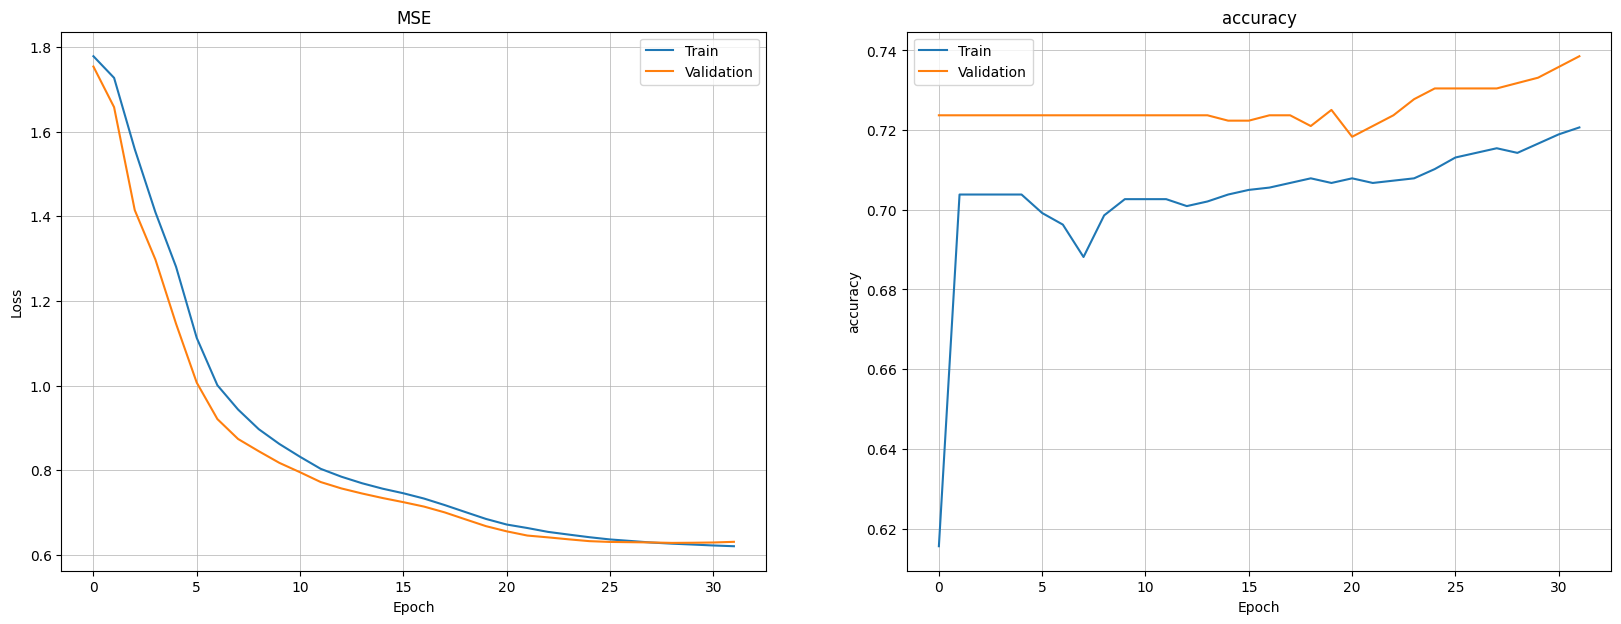

In [170]:
%%time
# 1 - Initialising the RNN model
# ==================================== #
model_1 = init_model(X_train, y_train)
model_1.summary()

# 2 - Training
# ====================================
model, history = fit_model(model_1, verbose=1)
plot_history(history);

# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print("-"*50)
print(f"The LSTM accuracy on the test set is equal to {round(res[1],2)}, (meaning the model is guessing the correct predictions {round(res[1]*100,2)}% of the time).")

In [171]:
model_1.predict(X_test).shape

5/5 [==============================] - 0s 3ms/step


(150, 7, 6)

In [183]:
np.round(model_1.predict(X_test)[80],2)

5/5 [==============================] - 0s 3ms/step


array([[0.  , 0.  , 0.  , 0.01, 0.25, 0.74],
       [0.  , 0.  , 0.  , 0.  , 0.29, 0.71],
       [0.  , 0.  , 0.  , 0.  , 0.32, 0.67],
       [0.  , 0.  , 0.  , 0.01, 0.31, 0.68],
       [0.  , 0.  , 0.  , 0.01, 0.28, 0.71],
       [0.  , 0.  , 0.  , 0.01, 0.31, 0.68],
       [0.  , 0.  , 0.  , 0.  , 0.36, 0.64]], dtype=float32)

### (3.2) 🎁 Baseline with a horizon

👉 (*Reminder*) ***In Time Series, an "intuitive" baseline model is to repeat the last seen value as (a) prediction(s) for the future value(s)*** you want to forecast, as illustrated down below!

<img src = "https://github.com/davydw/public-pictures/blob/main/last_seen_value_with_horizon.png?raw=true" width = 600 height = 300>

🎁 **The Last Seen Value Baseline Model** 

Let's go together through the function `last_seen_value_baseline` which:
- (_input_) takes a pair $(X, y)$ 
- (_output_) computes the MAE of the `"repeated last seen value"`  baseline model

In [ ]:
TARGET_COLUMN_IDX = 1 # the second column of each fold corresponds to the temperature

def last_seen_value_baseline(X, y):

    # How many values do you want to predict in the future ?
    output_length = y.shape[-1]
    
    # For each sequence, let's consider the last seen value
    # and only the temperature column
    last_seen_values = X[:,-1, TARGET_COLUMN_IDX].reshape(-1,1)

    # We need to duplicate these values as many times as output_length
    # The author of this notebook did not know how to do it, so they searched on Stackoverflow
    # and found this nice np.repeat in Numpy, which is self-explanatory
    repeated = np.repeat(last_seen_values, axis = 1, repeats = output_length)

    return np.mean(np.abs(y_test - repeated))

🕵🏻‍♀️ What is the performance of the "last seen value baseline model" on the <font color=orange>**test**</font> set?

In [ ]:
# 1 - Evaluation of the Baseline Model
# ====================================
mae_baseline = last_seen_value_baseline(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(mae_baseline,2)} Celsius degrees")

# 4 - Comparison with the LSTM model
# ====================================
print(f"- The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")
print(f"👉 Improvement/decrease of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/mae_baseline))*100,2)} % 👈")

<u><b><i>Warnings:</i></b></u>

* Do you remember the challenge `Predict weather temperature` where we were trying to predict the temperature in three hours, i.e. ***the next data point***? We were able to improve the MAE by 30-40% on the LSTM vs. the baseline for every fold, and the MAE was more or less between 1 and 2 degrees Celsius.

* <font color=red>***The more data points in the future we try to predict, the higher your MAE will be!***</font>

* *It is more and more frequent to see a 4/5 Celsius degrees - difference between the real temperature in seven days and the currently predicted value!*

### (3.3) 💻 Cross-Validation

ℹ️ Reminders of the global variables in this notebook:

In [ ]:
# Folds
print('##### FOLDS ##### ')
print(f'- FOLD_LENGTH = {FOLD_LENGTH} timesteps = {3} years x {365} days x {8} records per day')
print(f'- FOLD_STRIDE = {FOLD_STRIDE} timesteps = {(365/2)} days x {8} records per day = sliding each semester')

# Chronological Train Test Split
print('##### TRAIN TEST SPLIT #####')
print(f'- TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print(f'- N_TRAIN = {N_TRAIN}')
print(f'- N_TEST = {N_TEST}')

# Inputs
print('##### INPUTS #####')
print(f'- INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/8)} days x {8} records per day = {int(INPUT_LENGTH/8/7)} weeks')
print(f'- N_FEATURES = {N_FEATURES}') 

# Outputs
print('##### OUTPUTS #####')
print(f'- OUTPUT_LENGTH = {OUTPUT_LENGTH} timesteps = {int(OUTPUT_LENGTH/8)} day(s) x {8} records per day')
print(f"- Trying to predict:{TARGET}")
print(f'- N_TARGETS = {N_TARGETS}') 

# Parameters
print('##### PARAMETERS #####')
print(f'- HORIZON = {HORIZON} timesteps = {int(HORIZON/8)} day(s) x {8} records per day')


In [ ]:
# Remember how many folds do we have ?
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
print(f"WARNING, we have {len(folds)} FOLDS, it may take a long time to run...!")

🎁 **Cross-validating the LSTM and the baseline** 

_Let's go together through the following code_ 👇

In [ ]:
# Let's reload the dataset, just in case
url = "https://wagon-public-datasets.s3.amazonaws.com/deep_learning_datasets/weather_every_three_hours_engineered.csv"
df = pd.read_csv(url).drop(columns = ['Unnamed: 0'])

In [ ]:
list_of_mae_baseline_model = []
list_of_mae_recurrent_model = []
    
# 1 - Creating FOLDS
# =======================================================
    
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
    
for fold_id, fold in enumerate(folds):    
    
    # 2 - CHRONOLOGICAL TRAIN TEST SPLIT of the current FOLD
    # =======================================================    
    
    (fold_train, fold_test) = train_test_split(fold = fold, 
                                               train_test_ratio = TRAIN_TEST_RATIO, 
                                               input_length = INPUT_LENGTH, 
                                               horizon = HORIZON) 
    
    # 3 - Scanninng fold_train and fold_test for SEQUENCES 
    # =======================================================       
    
    X_train, y_train = get_X_y(fold = fold_train, 
                               horizon = HORIZON, 
                               input_length = INPUT_LENGTH, 
                               output_length = OUTPUT_LENGTH, 
                               stride = STRIDE)
    
    X_test, y_test = get_X_y(fold_test, 
                             horizon = HORIZON, 
                             input_length = INPUT_LENGTH, 
                             output_length = OUTPUT_LENGTH,
                             stride = STRIDE)
    
    # 4.1 - Baseline Model
    # =======================================================
    mae_baseline = last_seen_value_baseline(X_test, y_test)
    list_of_mae_baseline_model.append(mae_baseline)
    
    print("-"*50)
    print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")        
    
    
    # 4.2 - LSTM Model
    # =======================================================
    
    # Initializing the LSTM Model
    model = init_model(X_train, y_train)
    # Training
    model, history = fit_model(model, verbose=0)
    # Evaluation
    res = model.evaluate(X_test, y_test, verbose = 0)
    mae_lstm = res[1]
    
    list_of_mae_recurrent_model.append(mae_lstm)
    
    print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
    
    # 4.3 - Comparison LSTM vs Baseline for the current fold
    # =======================================================
    print(f"🏋🏽‍♂️ Improvement/Decrease vs. Baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")      

In [ ]:
cv_mae_baseline = np.mean(list_of_mae_baseline_model)
cv_mae_lstm = np.mean(list_of_mae_recurrent_model)

print("-"*50)
print(f"Average MAE baseline = {round(cv_mae_baseline, 2)}")    
print(f"Average LSTM baseline = {round(cv_mae_lstm, 2)}")    
print(f"🏋🏽‍♂️ Improvement/Decrease vs. Baseline: {round((1 - (cv_mae_lstm/cv_mae_baseline))*100,2)} % \n")      

🏁 Congratulations for finishing this day about RNN!

🃏 Don't forget your flashcards!

## 🏁 Final words

* 🤯 Predicting the temperature for 7 days every 3 hours, after waiting for 7 days, is not an easy task at all.
    - The LSTM model did not perform well on some folds
    - 5 degrees is a high MAE, one should take into account how "volatile" the temperature has been over the last two decades...

<hr>


* 🕵🏻 We may need weather data from other cities.
* 🤔 If you plan to use Recurrent Neural Networks during your project, ask your Batch Mananger and the most experienced teachers and TAs if about the quality of your data and the feasibility of your projects.
* 😇 Keep the morale high, RNNs are complex networks but they are pretty useful for _Natural Language Processing_. Stay tuned!

<hr>

#### Bonus: what is the main difficulty when trying to regress multiple targets in RNN ? 

- *Optional question only for very advanced students!*
- *For 99% of the students: read it later :) it's time to go home!*

🕵🏻‍♂️ We could have also tried to predict to <b>predict multiple targets</b>... which would have complexified the problem! 

<hr>

<details>
        <summary><i>Why, you ask ?</i></summary>
    
Imagine that you want to predict `N_TARGETS = 3` for 7 days in the future `OUTPUT_LENGTH = 7 x 8  = 56 timesteps`
    
- 🌡 `T (degC)` = temperature in Celsius degrees
- ♒️ `p (mbar)` = atmospheric air pressure in millibars
- 💦 `rh (%)` = relative humidity expressed as a percent 
    
👍 The predictive Dense Layer in your architecture will contain `3 x (7 x 8) = 168` neurons, that is totally doable. 
    
☢️ However when you compile the model, you will choose `metrics = ['mae']` and will evaluate your model on a metric which doesn't make any sense because you are mixing absolute errors of temperature, air pressure and relative humidity... ***You should create a custom metrics which computes one mae per target*** for example. It is possible  but for this recap, we will stay focused on one feature. Feel free to think about this question if your data science project needs it! </details>        